In [1]:
import pandas as pd
import numpy as np

In [2]:
def get_data(drop_8000=True):
    df = pd.read_csv('../raw_data/enriched_CT_PM.csv')
    df.drop(columns='Unnamed: 0', inplace=True)
    if drop_8000:
        df = df[df['n_trials'] < 8000]
    return df

In [3]:
df = get_data()

In [4]:
df.head(2)

,Medicine name,Therapeutic area,INN,Authorisation status,Generic,Biosimilar,Orphan medicine,First published,n_trials,status_not_yet_recruiting,...,org_other_gov,phase_early_1,phase_not_applicable,phase_1,phase_2,phase_3,phase_4,pm_results,pm_titles,pm_abstracts
0,DuoTrav,"Open-Angle Glaucoma, Ocular Hypertension",travoprost / timolol,0,0,0,0,2018-02-15 01:00:00,54,0,...,2,0,2,1,2,17,30,44,Comparison of the efficacy and safety of fixed...,Combining two medications in one bottle may im...
1,Palynziq,Phenylketonurias,pegvaliase,0,0,0,1,2019-05-29 13:43:00,12,0,...,0,0,0,1,4,3,0,11,Evidence- and consensus-based recommendations ...,Phenylketonuria (PKU) is a rare metabolic diso...


In [5]:
len(df['Therapeutic area'].unique())

513

In [6]:
len(df['INN'].unique())

786

In [9]:
df['Therapeutic area'].unique()

array(['Open-Angle Glaucoma, Ocular Hypertension', 'Phenylketonurias',
       'Hypertension',
       'Uterine Cervical Neoplasms, Small Cell Lung Carcinoma',
       'Depressive Disorder', 'Influenza Human', 'Osteoporosis',
       'Secondary Hyperparathyroidism, Hypercalcemia',
       'Hidradenitis Suppurativa, Psoriasis, Crohn Disease, Uveitis, Arthritis, Rheumatoid Arthritis, Ulcerative Colitis, Ankylosing Spondylitis, Psoriatic Arthritis',
       'Retinal Diseases', 'Circadian Rhythm Sleep Disorders',
       'Head and Neck Neoplasms, Non-Small-Cell Lung Carcinoma, Adenocarcinoma, Prostatic Neoplasms, Breast Neoplasms',
       'Castration-Resistant Prostatic Neoplasms',
       'Hidradenitis Suppurativa, Ankylosing Spondylitis, Psoriasis, Juvenile Rheumatoid Arthritis, Uveitis',
       'Radionuclide Imaging', 'Cystic Fibrosis',
       'Non-Small-Cell Lung Carcinoma',
       'Chronic Obstructive Pulmonary Disease',
       'Chronic Hepatitis C, Chronic Hepatitis B',
       'Type 1 Diabet

In [7]:
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
def clean(x):
    for punctuation in string.punctuation:
        x = x.replace(punctuation, '')
    x = x.lower()
    x = ''.join(word for word in x if not word.isdigit())
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(x)
    x = [w for w in word_tokens if not w in stop_words]
    x = ' '.join(x)
    return x

In [8]:
ta = df[['Therapeutic area','INN','Authorisation status']].copy()

In [9]:
ta.head(2)

,Therapeutic area,INN,Authorisation status
0,"Open-Angle Glaucoma, Ocular Hypertension",travoprost / timolol,0
1,Phenylketonurias,pegvaliase,0


### it is worth cleaning the therapeutic area - maybe, maybe not...

In [10]:
ta['thera_clean'] = ta['Therapeutic area'].apply(clean)

In [11]:
ta.head(2)

,Therapeutic area,INN,Authorisation status,thera_clean
0,"Open-Angle Glaucoma, Ocular Hypertension",travoprost / timolol,0,openangle glaucoma ocular hypertension
1,Phenylketonurias,pegvaliase,0,phenylketonurias


----
## ASIDE TO SEE IF THIS WORKS

In [15]:
ta_auth = ta[ta['Authorisation status'] == 0].copy()
ta_unauth = ta[ta['Authorisation status'] == 1].copy()

In [18]:
ta_unauth['thera_clean'].unique()

array(['substance withdrawal syndrome alcohol abstinence',
       'acute myeloid leukemia', 'breast neoplasms ovarian neoplasms',
       'prostatic neoplasms', 'osteoporosis',
       'duchenne muscular dystrophy', 'venous thromboembolism',
       'multiple myeloma', 'amyotrophic lateral sclerosis',
       'rheumatoid arthritis', 'mastocytosis', 'schizophrenia',
       'breast neoplasms', 'hypogonadism',
       'cachexia nonsmallcell lung carcinoma anorexia nonsmallcell lung carcinoma',
       'colorectal neoplasms', 'corneal diseases cystinosis',
       'inborn urea cycle disorders', 'nonhodgkin lymphoma',
       'pancreatic neoplasms', 'heart failure', 'multiple sclerosis',
       'gastrointestinal stromal tumors', 'hypercholesterolemia',
       'obesity', 'asthma', 'alzheimer disease', 'gaucher disease',
       'tcell lymphoma', 'migraine disorders',
       'infectious skin diseases soft tissue infections', 'fibromyalgia',
       'friedreich ataxia', 'irritable bowel syndrome', 'angi

In [26]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer().fit(ta_unauth['thera_clean'])

data_vectorized = vectorizer.transform(ta_unauth['thera_clean'])

lda_model = LatentDirichletAllocation(n_components=18).fit(data_vectorized)

In [27]:
topic_dict = {}
for idx, topic in enumerate(lda_model.components_):
    topic_dict[idx] = [(vectorizer.get_feature_names()[i]) for i in topic.argsort()[:-10 - 1:-1]]

In [28]:
print(topic_dict)

{0: ['neoplasms', 'multiple', 'syndrome', 'sclerosis', 'disorders', 'hypercholesterolemia', 'disease', 'diseases', 'breast', 'tissue'], 1: ['acute', 'leukemia', 'myeloid', 'hypogonadism', 'heart', 'failure', 'neoplasms', 'multiple', 'syndrome', 'sclerosis'], 2: ['migraine', 'neoplasms', 'disorders', 'dystrophy', 'muscular', 'duchenne', 'ovarian', 'breast', 'multiple', 'syndrome'], 3: ['schizophrenia', 'thromboembolism', 'venous', 'neoplasms', 'multiple', 'syndrome', 'sclerosis', 'disorders', 'hypercholesterolemia', 'disease'], 4: ['breast', 'friedreich', 'ataxia', 'neoplasms', 'multiple', 'syndrome', 'sclerosis', 'disorders', 'hypercholesterolemia', 'disease'], 5: ['neoplasms', 'asthma', 'prostatic', 'pancreatic', 'multiple', 'syndrome', 'sclerosis', 'disorders', 'hypercholesterolemia', 'disease'], 6: ['carcinoma', 'nonsmallcell', 'lung', 'anorexia', 'cachexia', 'neoplasms', 'multiple', 'syndrome', 'sclerosis', 'disorders'], 7: ['infections', 'soft', 'skin', 'infectious', 'diseases', '

In [30]:
area_vector = vectorizer.transform(ta_unauth['Therapeutic area'])
lda_vectors = lda_model.transform(area_vector)

In [46]:
lda_vectors

array([[0.01717681, 0.01717681, 0.01717681, 0.01717681, 0.01717681,
        0.01717681, 0.01717681, 0.01717681, 0.01717681, 0.01717681,
        0.01717681, 0.01717681, 0.01717681, 0.01717681, 0.01717681,
        0.01717681, 0.01717681, 0.70799428],
       [0.02033474, 0.65430934, 0.02033474, 0.02033474, 0.02033474,
        0.02033474, 0.02033474, 0.02033474, 0.02033474, 0.02033474,
        0.02033474, 0.02033474, 0.02033474, 0.02033474, 0.02033474,
        0.02033474, 0.02033474, 0.02033474],
       [0.02064697, 0.02064697, 0.64900158, 0.02064697, 0.02064697,
        0.02064697, 0.02064697, 0.02064697, 0.02064697, 0.02064697,
        0.02064697, 0.02064697, 0.02064697, 0.02064697, 0.02064697,
        0.02064697, 0.02064697, 0.02064697],
       [0.02316301, 0.02316301, 0.02316301, 0.02316301, 0.02316301,
        0.60622883, 0.02316301, 0.02316301, 0.02316301, 0.02316301,
        0.02316301, 0.02316301, 0.02316301, 0.02316301, 0.02316301,
        0.02316301, 0.02316301, 0.02316301],
    

In [47]:
vector_df = pd.DataFrame(lda_vectors)

In [54]:
lda_vectors[0].argmax()

17

In [55]:
groups = [vector.argmax() for vector in lda_vectors]

In [58]:
ta_unauth['thera_groups'] = groups

In [60]:
ta_unauth.head(5)

,Therapeutic area,INN,Authorisation status,thera_clean,thera_groups
448,"Substance Withdrawal Syndrome, Alcohol Abstinence",sodium oxybate,1,substance withdrawal syndrome alcohol abstinence,17
893,Acute Myeloid Leukemia,quizartinib,1,acute myeloid leukemia,1
1012,"Breast Neoplasms, Ovarian Neoplasms",doxorubicin,1,breast neoplasms ovarian neoplasms,2
1041,Prostatic Neoplasms,cabazitaxel,1,prostatic neoplasms,5
1094,Osteoporosis,abaloparatide,1,osteoporosis,9


so - an element of success perhaps - but this needs applying to the whole dataset...  
and maybe don't clean the texts either.
----

### Whole dataset

In [169]:
ta.head(2)

,Therapeutic area,INN,Authorisation status,thera_clean,thera_groups
0,"Open-Angle Glaucoma, Ocular Hypertension",travoprost / timolol,0,openangle glaucoma ocular hypertension,12
1,Phenylketonurias,pegvaliase,0,phenylketonurias,0


In [20]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(ngram_range=(1,1)).fit(ta['thera_clean'])

data_vectorized = vectorizer.transform(ta['thera_clean'])

lda_model = LatentDirichletAllocation(n_components=9, random_state=1).fit(data_vectorized)

In [21]:
area_vector = vectorizer.transform(ta['Therapeutic area'])
lda_vectors = lda_model.transform(area_vector)

In [22]:
groups = [vector.argmax() for vector in lda_vectors]
ta['thera_groups'] = groups

In [23]:
ta.head()

,Therapeutic area,INN,Authorisation status,thera_clean,thera_groups
0,"Open-Angle Glaucoma, Ocular Hypertension",travoprost / timolol,0,openangle glaucoma ocular hypertension,2
1,Phenylketonurias,pegvaliase,0,phenylketonurias,5
2,Hypertension,irbesartan / hydrochlorothiazide,0,hypertension,6
3,"Uterine Cervical Neoplasms, Small Cell Lung Ca...",topotecan,0,uterine cervical neoplasms small cell lung car...,2
4,Hypertension,irbesartan / hydrochlorothiazide,0,hypertension,6


In [24]:
ta.tail()

,Therapeutic area,INN,Authorisation status,thera_clean,thera_groups
1217,Candidiasis,efungumab,1,candidiasis,7
1218,Major Depressive Disorder,Agomelatine,1,major depressive disorder,8
1219,Major Depressive Disorder,Agomelatine,1,major depressive disorder,8
1220,Chronic Hepatitis C,interferon alfa-2a,1,chronic hepatitis c,4
1221,Sarcoma,trabectedin,1,sarcoma,2


In [25]:
ta.thera_groups.value_counts()

0    192
4    172
6    157
7    138
3    133
5    119
2    109
1    103
8     97
Name: thera_groups, dtype: int64

In [26]:
group_auth_thera = ta.groupby(['thera_groups','Authorisation status']).agg({'Therapeutic area':'count'})

In [27]:
group_auth_thera.groupby(level=0).apply(lambda x: 100*x/float(x.sum()))

Therapeutic area
thera_groups Authorisation status                  
0            0                            96.354167
             1                             3.645833
1            0                            94.174757
             1                             5.825243
2            0                            94.495413
             1                             5.504587
3            0                            97.744361
             1                             2.255639
4            0                            97.093023
             1                             2.906977
5            0                            97.478992
             1                             2.521008
6            0                            96.815287
             1                             3.184713
7            0                            96.376812
             1                             3.623188
8            0                            91.752577
             1                             8.247423

and nothing absolutely jumps out here - perhaps group 11 with 8%

In [28]:
topic_dict = {}
for idx, topic in enumerate(lda_model.components_):
    topic_dict[idx] = [(vectorizer.get_feature_names()[i]) for i in topic.argsort()[:-10 - 1:-1]]

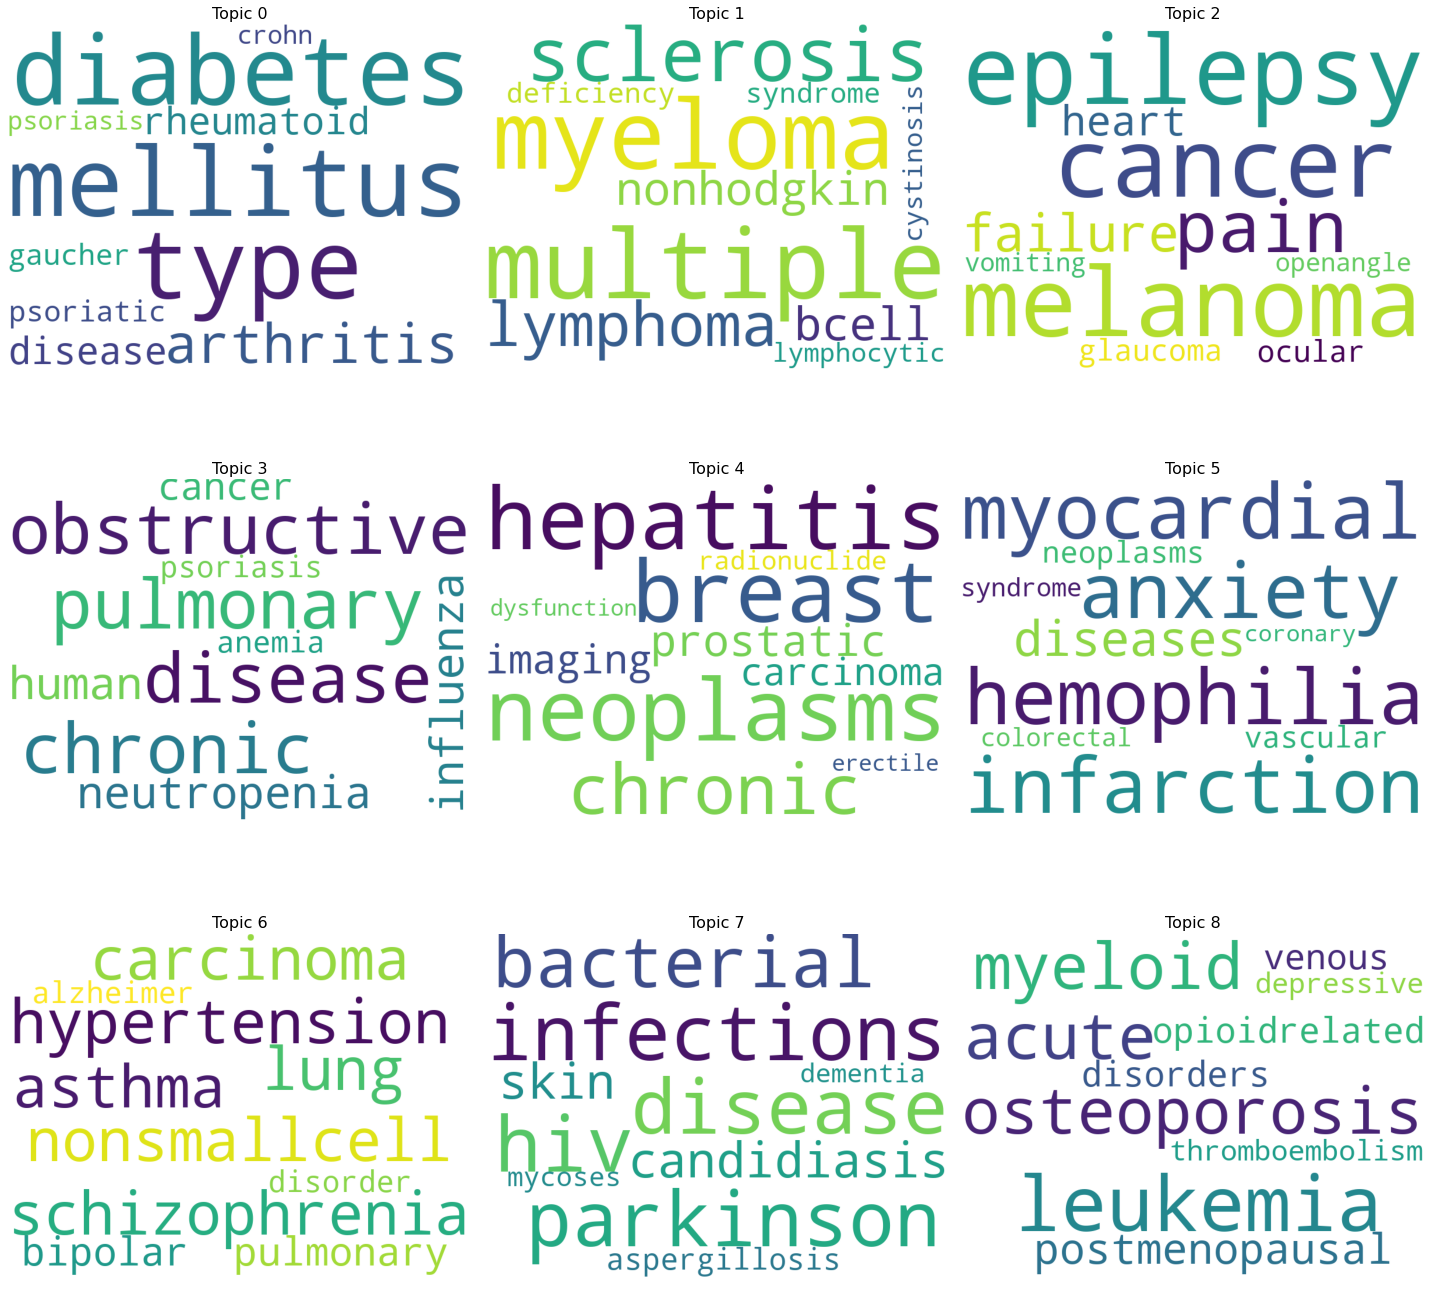

In [29]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

cloud = WordCloud(width = 800, height = 600, 
                  background_color ='white', 
                  stopwords = [], 
                  min_font_size = 10)

fig, axes = plt.subplots(3, 3, figsize=(20,20), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = ' '.join(topic_dict[i])
    cloud.generate(topic_words)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()

### Model with new feature

In [30]:
ta.shape

(1220, 5)

In [31]:
df.head(2)

,Medicine name,Therapeutic area,INN,Authorisation status,Generic,Biosimilar,Orphan medicine,First published,n_trials,status_not_yet_recruiting,...,org_other_gov,phase_early_1,phase_not_applicable,phase_1,phase_2,phase_3,phase_4,pm_results,pm_titles,pm_abstracts
0,DuoTrav,"Open-Angle Glaucoma, Ocular Hypertension",travoprost / timolol,0,0,0,0,2018-02-15 01:00:00,54,0,...,2,0,2,1,2,17,30,44,Comparison of the efficacy and safety of fixed...,Combining two medications in one bottle may im...
1,Palynziq,Phenylketonurias,pegvaliase,0,0,0,1,2019-05-29 13:43:00,12,0,...,0,0,0,1,4,3,0,11,Evidence- and consensus-based recommendations ...,Phenylketonuria (PKU) is a rare metabolic diso...


In [32]:
numeric_features = ['phase_4',
 'Orphan medicine',
 'org_indiv',
 'n_trials',
 'status_terminated',
 'phase_2',
 'phase_3',
 'status_not_yet_recruiting',
 'org_fed',
 'org_nih']

In [33]:
df_select = pd.concat([df[numeric_features], ta.thera_groups, df['Authorisation status']], axis=1)

In [34]:
df_select.head(2)

,phase_4,Orphan medicine,org_indiv,n_trials,status_terminated,phase_2,phase_3,status_not_yet_recruiting,org_fed,org_nih,thera_groups,Authorisation status
0,30,0,0,54,3,2,17,0,0,0,2,0
1,0,1,0,12,0,4,3,0,0,0,5,0


In [35]:
df_select['Authorisation status'].value_counts()

0    1172
1      48
Name: Authorisation status, dtype: int64

In [36]:
X = df_select.drop(columns='Authorisation status')
y = df_select['Authorisation status']

In [37]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [38]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC

In [39]:
preprocess = ColumnTransformer([('scale', RobustScaler(), numeric_features),
                                ('ohe', OneHotEncoder(), ['thera_groups'])])

In [40]:
final_pipe = Pipeline([
    ('preprocessing', preprocess),
    ('rfcl', RandomForestClassifier(class_weight='balanced'))])

In [41]:
y_pred = cross_val_predict(final_pipe, X_train, y_train, cv=5)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       938
           1       0.33      0.16      0.21        38

    accuracy                           0.95       976
   macro avg       0.65      0.57      0.60       976
weighted avg       0.94      0.95      0.95       976



so an improvement in the precision for our rejected drugs  

---